Uncovering U.S. Macroeconomic Dynamics: A VAR-Based Analysis of Causality and Economic Shocks
--

The project explores long-term interactions among key U.S. macroeconomic indicators from Jan 1978–May 2025 using multivariate time series analysis.

**Variables studied:**

**Personal Consumption Expenditure (PCE):** Measures consumer spending.

**Money Supply (M2):** Reflects monetary environment and policy.

**Industrial Production Index (INDPRO):** Captures manufacturing and supply-side activity.

**University of Michigan Consumer Sentiment Index (UMCSENT):** Gauges consumer confidence and expectations.

**Analytical Methods:**
Vector Autoregression (VAR),
Granger causality tests,
Impulse Response Functions (IRF) and
Forecast Error Variance Decomposition (FEVD)

**Goal:** Understand how changes in one variable impact others and the broader economy over time.

**Significance:** Results inform economic policy making, financial risk management, and business planning by highlighting interrelationships and the transmission of shocks across the economy.

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [77]:
#pip install openpyxl


Step 1: Importing and Inspecting the Data
-

We begin by loading the dataset TS.xlsx, which contains monthly observations of four key U.S. macroeconomic variables (UMSCENT,M2,PCE and INDPRO) from January 1978 to May 2025.

The Month column represents the timestamp for each observation. We use pandas to read the Excel file and display the first five rows using df.head() to confirm the dataset has been loaded correctly and is in the expected format.

From the output, we can see that the dataset appears well-structured with no obvious missing values in the initial rows.

In [5]:
import pandas as pd
df = pd.read_excel("TS.xlsx")
print(df.head())

       Month  UMCSENT      M2     PCE   INDPRO
0 1978-01-01     83.7  1279.7  1329.5  47.7512
1 1978-02-01     84.3  1285.5  1355.1  48.0098
2 1978-03-01     78.8  1292.2  1377.5  48.9358
3 1978-04-01     81.6  1300.4  1396.4  49.9074
4 1978-05-01     82.9  1310.5  1412.0  50.1513


In [6]:
df

,Month,UMCSENT,M2,PCE,INDPRO
0,1978-01-01,83.7,1279.7,1329.5,47.7512
1,1978-02-01,84.3,1285.5,1355.1,48.0098
2,1978-03-01,78.8,1292.2,1377.5,48.9358
3,1978-04-01,81.6,1300.4,1396.4,49.9074
4,1978-05-01,82.9,1310.5,1412.0,50.1513
...,...,...,...,...,...
564,2025-01-01,71.7,21519.8,20370.0,102.9343
565,2025-02-01,64.7,21613.5,20436.3,104.0003
566,2025-03-01,57.0,21706.4,20578.5,103.7483
567,2025-04-01,52.2,21862.4,20622.0,103.8216


Step 2: DateTime Conversion and Indexing
-

The Month column is converted to DateTime format to ensure proper handling of time series operations (such as resampling, lagging, or plotting trends over time).

We then set the Month column as the index of the DataFrame, making it a time series index. This allows libraries like statsmodels and pandas to recognize the temporal ordering of observations, which is crucial for forecasting and causality tests.

In [7]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)


In [8]:
df

,UMCSENT,M2,PCE,INDPRO
Month,,,,
1978-01-01,83.7,1279.7,1329.5,47.7512
1978-02-01,84.3,1285.5,1355.1,48.0098
1978-03-01,78.8,1292.2,1377.5,48.9358
1978-04-01,81.6,1300.4,1396.4,49.9074
1978-05-01,82.9,1310.5,1412.0,50.1513
...,...,...,...,...
2025-01-01,71.7,21519.8,20370.0,102.9343
2025-02-01,64.7,21613.5,20436.3,104.0003
2025-03-01,57.0,21706.4,20578.5,103.7483


Step 3: Dataset Overview
--
Before conducting time series modeling and analysis, an initial exploration of the dataset was performed.
The following code snippets provide a basic summary of the dataset’s shape, data types, and statistical characteristics:

In [9]:
df.shape

(569, 4)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 569 entries, 1978-01-01 to 2025-05-01
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UMCSENT  569 non-null    float64
 1   M2       569 non-null    float64
 2   PCE      569 non-null    float64
 3   INDPRO   569 non-null    float64
dtypes: float64(4)
memory usage: 22.2 KB


In [11]:
df.describe()

,UMCSENT,M2,PCE,INDPRO
count,569.000000,569.000000,569.000000,569.000000
mean,84.483304,7505.233392,8018.890158,81.062637
std,13.421012,5918.656808,5061.119951,19.604664
min,50.000000,1279.700000,1329.500000,46.871300
25%,73.600000,3133.300000,3643.300000,61.635200
50%,88.300000,5344.000000,7121.700000,89.500700
75%,94.400000,10731.500000,11372.600000,98.995500
max,112.000000,21942.000000,20622.000000,104.103800


Step 4: Time Series Visualization
--

To better understand the temporal behavior and trends of the macroeconomic indicators, individual line plots were created for each variable. These time series plots allow for visual inspection of trends, seasonality or cycles, volatility and structural breaks.

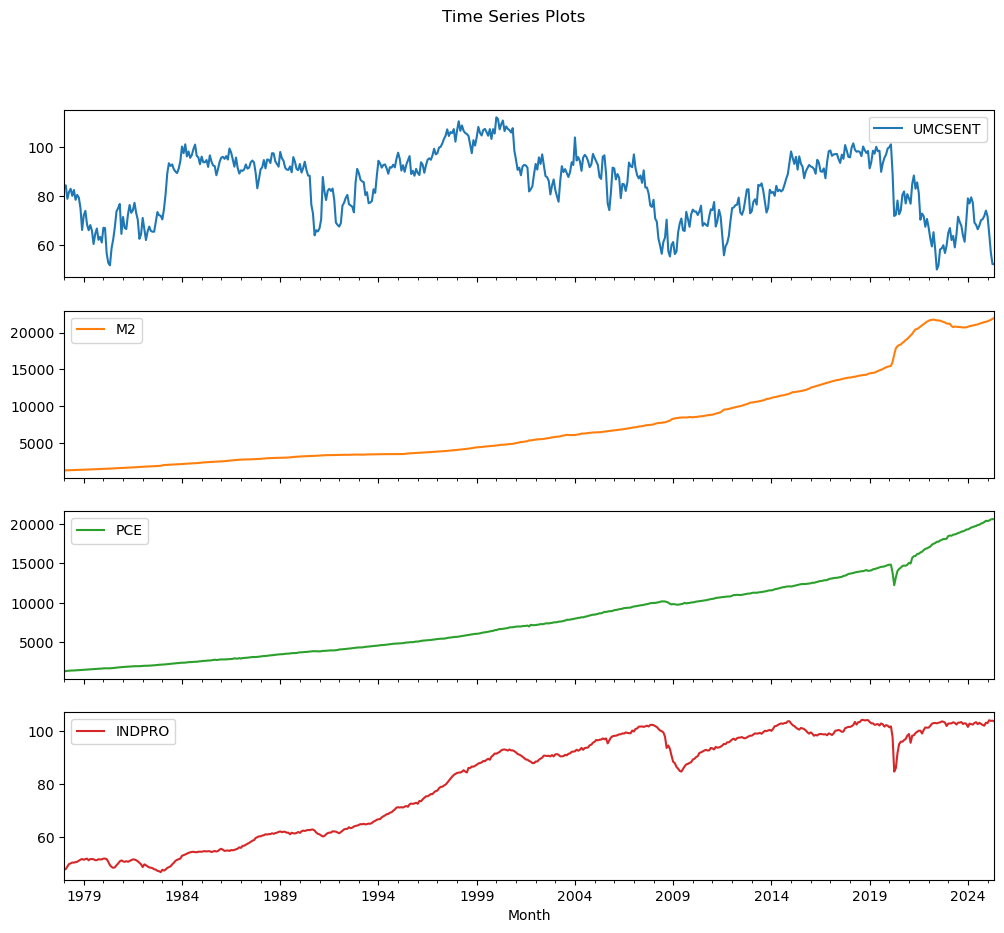

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Line plots
df[['UMCSENT', 'M2', 'PCE', 'INDPRO']].plot(subplots=True, figsize=(12, 10), title='Time Series Plots')
plt.show()

Visualizing Crisis Impact on Macroeconomic Indicators
-

To highlight the effects of major economic disruptions, time series plots were generated for each macroeconomic variable with crisis markers overlaid:

**🔴Red dashed line:** Start of the 2008 Global Financial Crisis (September 15, 2008 – Lehman Brothers collapse).

**🟢Green dashed line:** Start of the COVID-19 pandemic impact (March 1, 2020).

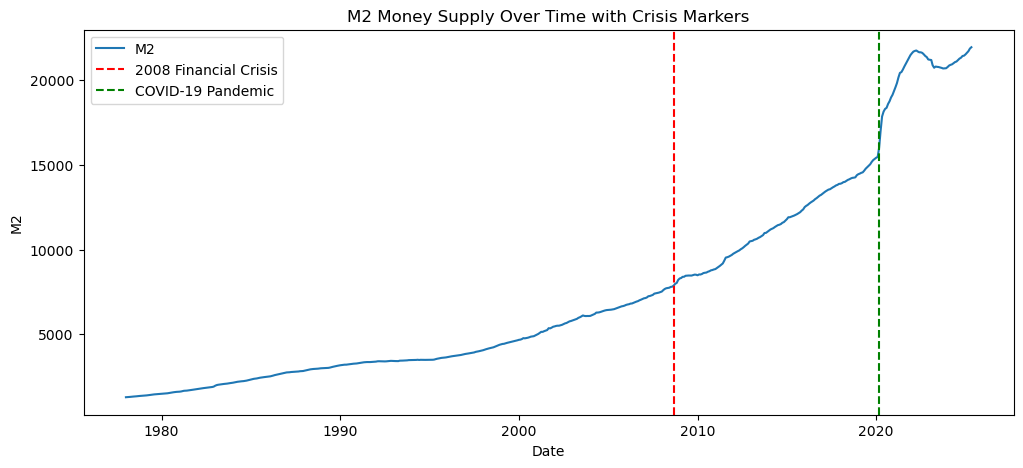

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(12,5))
plt.plot(df.index, df['M2'], label='M2')
plt.axvline(x=pd.to_datetime('2008-09-15'), color='r', linestyle='--', label='2008 Financial Crisis')
plt.axvline(x=pd.to_datetime('2020-03-01'), color='g', linestyle='--', label='COVID-19 Pandemic')
plt.title('M2 Money Supply Over Time with Crisis Markers')
plt.xlabel('Date')
plt.ylabel('M2')
plt.legend()
plt.show()


**Impact on M2:**

**2008:** M2 shows a steady growth, with no sharp disruption during the financial crisis. However, monetary policy responses (e.g., QE) likely contributed to the continued upward trend.

**2020:** A sudden, sharp spike in M2 is observed—reflecting aggressive monetary expansion by the Federal Reserve in response to COVID-19. This indicates liquidity injection into the economy at an unprecedented scale.

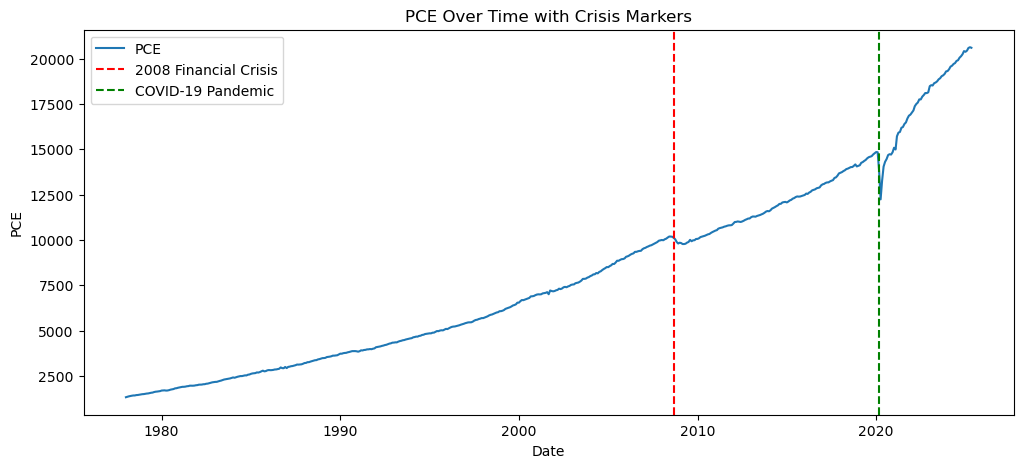

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(12,5))
plt.plot(df.index, df['PCE'], label='PCE')
plt.axvline(x=pd.to_datetime('2008-09-15'), color='r', linestyle='--', label='2008 Financial Crisis')
plt.axvline(x=pd.to_datetime('2020-03-01'), color='g', linestyle='--', label='COVID-19 Pandemic')
plt.title('PCE Over Time with Crisis Markers')
plt.xlabel('Date')
plt.ylabel('PCE')
plt.legend()
plt.show()

**Impact on PCE:**

**2008:** PCE growth temporarily flattens, indicating a decline in consumption demand, possibly due to uncertainty and rising unemployment.

**2020:** A sharp dip occurs at the onset of the pandemic, followed by a strong recovery—consistent with stimulus-driven consumer spending rebound. The rebound is sharper than in 2008.

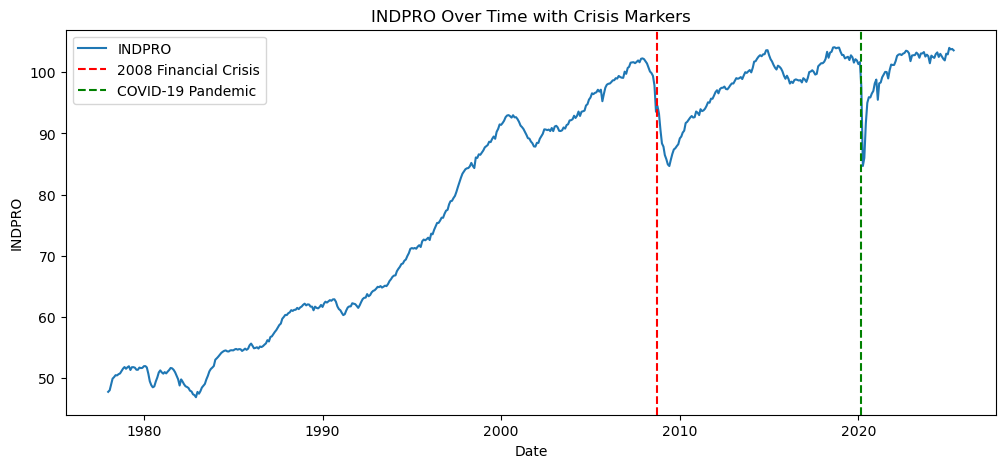

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(12,5))
plt.plot(df.index, df['INDPRO'], label='INDPRO')
plt.axvline(x=pd.to_datetime('2008-09-15'), color='r', linestyle='--', label='2008 Financial Crisis')
plt.axvline(x=pd.to_datetime('2020-03-01'), color='g', linestyle='--', label='COVID-19 Pandemic')
plt.title('INDPRO Over Time with Crisis Markers')
plt.xlabel('Date')
plt.ylabel('INDPRO')
plt.legend()
plt.show()

**Impact on INDPRO :**

**2008:** Shows a clear and steep decline, reflecting real economy contraction—reduced output, falling demand, and supply-side issues.

**2020:** Another sharp but shorter dip, followed by a relatively quick recovery. The shock was deeper in 2008, but COVID's impact was more abrupt and V-shaped in recovery.

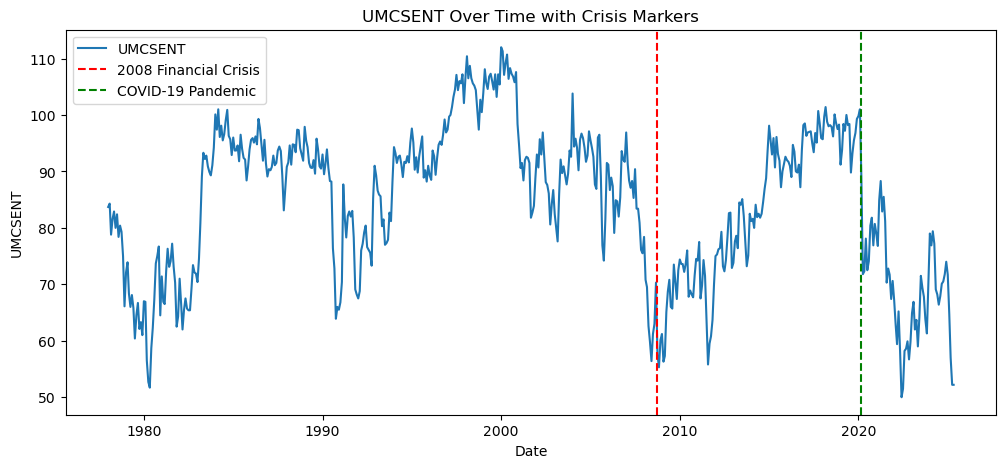

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(12,5))
plt.plot(df.index, df['UMCSENT'], label='UMCSENT')
plt.axvline(x=pd.to_datetime('2008-09-15'), color='r', linestyle='--', label='2008 Financial Crisis')
plt.axvline(x=pd.to_datetime('2020-03-01'), color='g', linestyle='--', label='COVID-19 Pandemic')
plt.title('UMCSENT Over Time with Crisis Markers')
plt.xlabel('Date')
plt.ylabel('UMCSENT')
plt.legend()
plt.show()

**Impact on UMCSENT  :**

**2008:** Experiences a dramatic drop during the financial crisis, showing consumers’ pessimism about the economy and future outlook.

**2020:** Also shows a steep decline, possibly sharper and more volatile than in 2008. The fear, uncertainty, and job insecurity during the pandemic heavily affected sentiment.

Step 5: Log Transformation of Variables
-

In [18]:
import numpy as np

To stabilize the variance and convert exponential growth trends into linear trends, we apply a natural logarithmic transformation to three of the four macroeconomic variables:

M2 → log_M2

PCE → log_PCE

INDPRO → log_INDPRO

We do not apply a log transformation to UMCSENT (Consumer Sentiment), as it is already an index and does not exhibit exponential growth characteristics like monetary or real activity variables.

Log-transforming these variables also makes the interpretation of percentage changes easier in later analysis (e.g., in differenced series, changes represent approximate growth rates).

In [19]:
#Converting variables to logarithmic scale
df_log = df.copy()
df_log['log_M2'] = np.log(df_log['M2'])
df_log['log_PCE'] = np.log(df_log['PCE'])
df_log['log_INDPRO'] = np.log(df_log['INDPRO'])


Step 6: Confirming the Transformed DataFrame
-

In [20]:
df_log.head()

,UMCSENT,M2,PCE,INDPRO,log_M2,log_PCE,log_INDPRO
Month,,,,,,,
1978-01-01,83.7,1279.7,1329.5,47.7512,7.154381,7.192558,3.866004
1978-02-01,84.3,1285.5,1355.1,48.0098,7.158903,7.211631,3.871405
1978-03-01,78.8,1292.2,1377.5,48.9358,7.164101,7.228026,3.890509
1978-04-01,81.6,1300.4,1396.4,49.9074,7.170427,7.241653,3.910169
1978-05-01,82.9,1310.5,1412.0,50.1513,7.178164,7.252762,3.915044


Step 7: ACF and PACF Analysis (Before Stationarity Transformation)
--
To examine the temporal structure and autocorrelation characteristics of the original time series, Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots were generated for the raw or log-transformed series: UMCSENT (raw), log_M2, log_PCE, log_INDPRO

These plots are useful for detecting non-stationarity and identifying structural characteristics

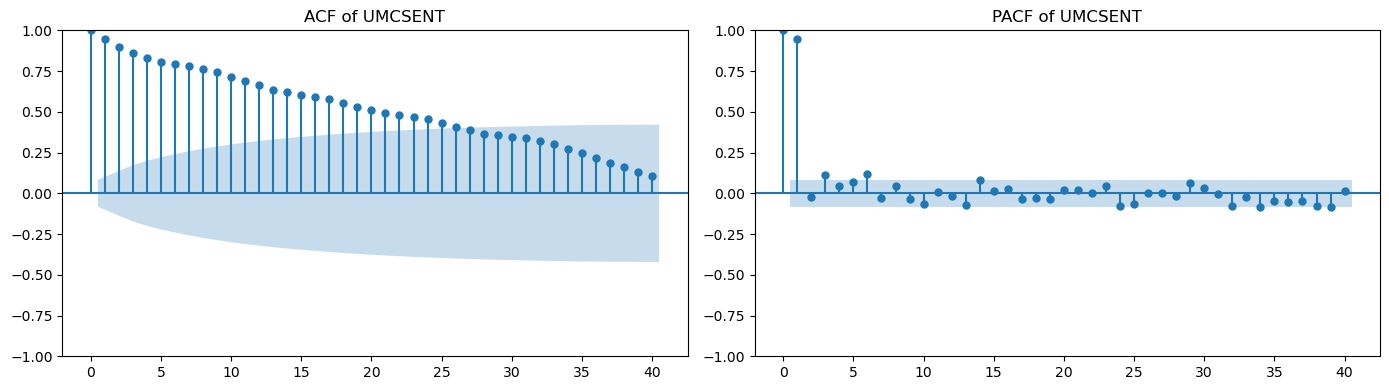

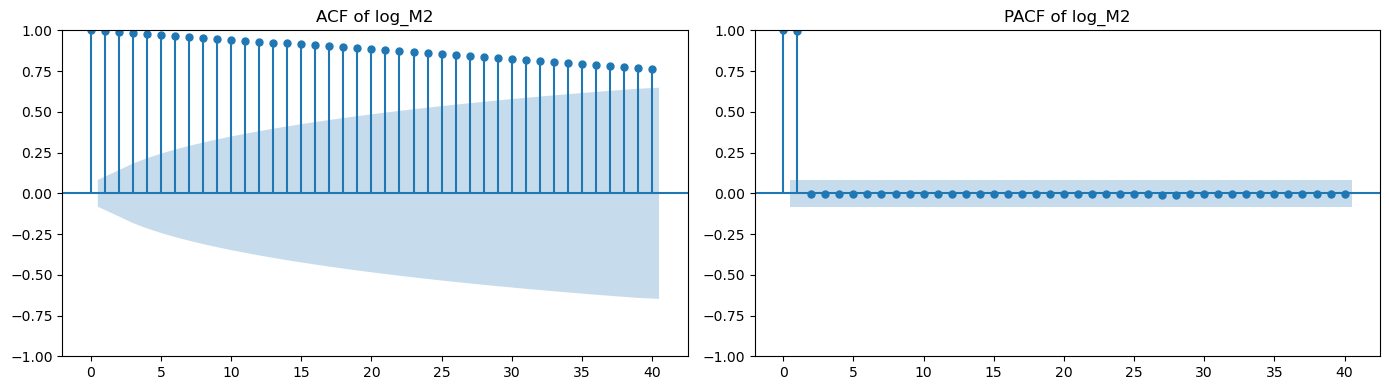

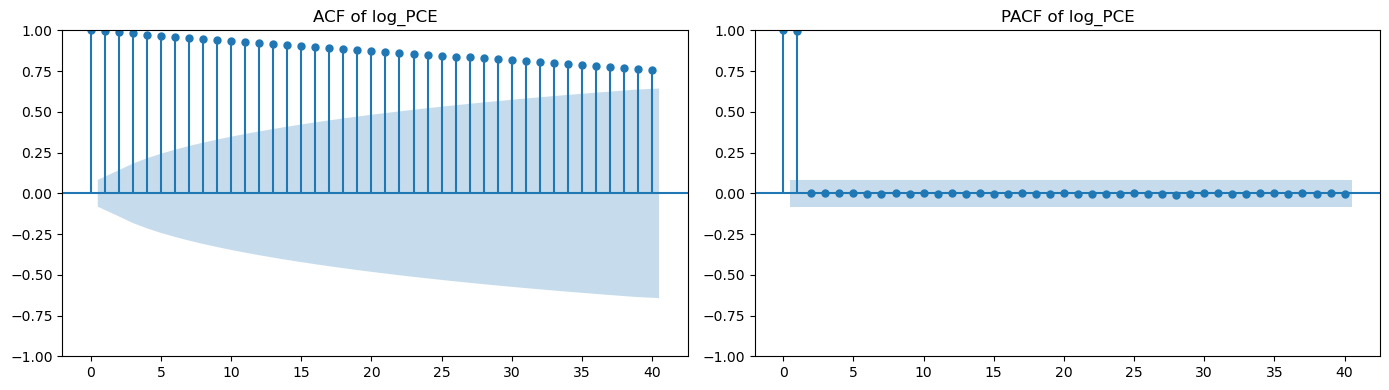

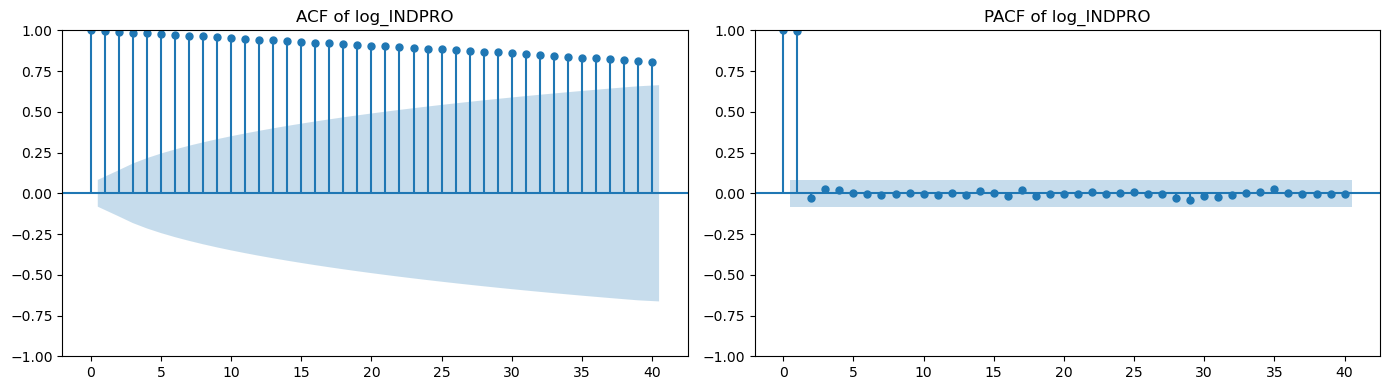

In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

variables = ['UMCSENT', 'log_M2', 'log_PCE', 'log_INDPRO']

for var in variables:
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    plot_acf(df_log[var].dropna(), ax=axes[0], lags=40)
    axes[0].set_title(f'ACF of {var}')
    plot_pacf(df_log[var].dropna(), ax=axes[1], lags=40, method='ywm')
    axes[1].set_title(f'PACF of {var}')
    plt.tight_layout()
    plt.show()

Step 8: Testing for Stationarity – ADF Test
-

We now assess the stationarity of each variable using the Augmented Dickey-Fuller (ADF) test, which checks for the presence of a unit root (a sign of non-stationarity).

Null Hypothesis (H₀): The series has a unit root (non-stationary).

Alternative Hypothesis (H₁): The series is stationary.

We apply the test to the following variables: log_M2 (Money Supply), log_PCE (Consumption Expenditure), log_INDPRO (Industrial Production) and UMCSENT (Consumer Sentiment)

For each variable, we inspect:

The ADF test statistic (more negative → stronger evidence against H₀)

The p-value (if < 0.05, we reject H₀ → series is stationary)

The critical values at the 1%, 5%, and 10% significance levels

🔍 Interpretation:
If a variable is found to be non-stationary, we will take its first difference in the next step to induce stationarity, which is essential for reliable VAR modeling and Granger causality analysis.

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
for col in ['log_M2', 'log_PCE', 'log_INDPRO', 'UMCSENT']:
    result = adfuller(df_log[col].dropna())
    print(f'ADF Test for {col}:')
    print(f'  Test Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    print(f'  Critical Values: {result[4]}')
    print('-' * 40)


ADF Test for log_M2:
  Test Statistic: -0.6181
  p-value: 0.8668
  Critical Values: {'1%': -3.442102384299813, '5%': -2.8667242618524233, '10%': -2.569531046591633}
----------------------------------------
ADF Test for log_PCE:
  Test Statistic: -2.9787
  p-value: 0.0369
  Critical Values: {'1%': -3.4421447800270673, '5%': -2.8667429272780858, '10%': -2.5695409929766093}
----------------------------------------
ADF Test for log_INDPRO:
  Test Statistic: -1.2145
  p-value: 0.6673
  Critical Values: {'1%': -3.4421447800270673, '5%': -2.8667429272780858, '10%': -2.5695409929766093}
----------------------------------------
ADF Test for UMCSENT:
  Test Statistic: -2.0859
  p-value: 0.2502
  Critical Values: {'1%': -3.4420185006698127, '5%': -2.8666873299250253, '10%': -2.5695113665058726}
----------------------------------------


log_M2, log_INDPRO, and UMCSENT have p-values > 0.05, so we fail to reject the null hypothesis. These series are non-stationary.

log_PCE has a p-value < 0.05, suggesting it is stationary at the 5% significance level. However, since we’ll be including other non-stationary variables in our multivariate analysis, we will difference all variables to maintain consistency.

📌 Conclusion:
Most variables are non-stationary in levels. Therefore, we will transform all four variables into first differences to achieve stationarity across the dataset before moving on to VAR modeling and Granger causality testing.

In [24]:
df_log['d_log_M2'] = df_log['log_M2'].diff()
df_log['d_log_INDPRO'] = df_log['log_INDPRO'].diff()
df_log['d_UMCSENT'] = df_log['UMCSENT'].diff()
df_log['d_log_PCE'] = df_log['log_PCE'].diff()
df_log.dropna(inplace=True)

Step 9: Making the Variables Stationary – First Differencing
-

Since most of our variables were non-stationary at level, we applied first differencing to each of them:

We now re-apply the ADF test to these differenced series.

In [25]:
for col in ['d_log_M2','d_log_PCE', 'd_log_INDPRO', 'd_UMCSENT']:
    result = adfuller(df_log[col].dropna())
    print(f'ADF Test for {col}:')
    print(f'  Test Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    print(f'  Critical Values: {result[4]}')
    print('-' * 40)


ADF Test for d_log_M2:
  Test Statistic: -4.7374
  p-value: 0.0001
  Critical Values: {'1%': -3.442102384299813, '5%': -2.8667242618524233, '10%': -2.569531046591633}
----------------------------------------
ADF Test for d_log_PCE:
  Test Statistic: -5.9894
  p-value: 0.0000
  Critical Values: {'1%': -3.4421447800270673, '5%': -2.8667429272780858, '10%': -2.5695409929766093}
----------------------------------------
ADF Test for d_log_INDPRO:
  Test Statistic: -6.2304
  p-value: 0.0000
  Critical Values: {'1%': -3.4421447800270673, '5%': -2.8667429272780858, '10%': -2.5695409929766093}
----------------------------------------
ADF Test for d_UMCSENT:
  Test Statistic: -13.6122
  p-value: 0.0000
  Critical Values: {'1%': -3.4420185006698127, '5%': -2.8666873299250253, '10%': -2.5695113665058726}
----------------------------------------


🟩 All differenced variables now have p-values < 0.05 and test statistics lower than the 1% critical value, indicating strong evidence against the null hypothesis of a unit root.

📌 Conclusion:
All series are now stationary after first differencing and ready to be included in a VAR model. This satisfies a key precondition for performing multivariate time series modeling and Granger causality testing reliably.

Step 10: Selecting the Optimal Lag Length for VAR
--

Before fitting a Vector Autoregression (VAR) model, we must determine the optimal lag length, which is crucial to accurately capturing the intertemporal dynamics among the variables.

We use the select_order() method from the statsmodels library to test multiple lag lengths (up to 12 lags) and choose the best one based on standard information criteria:

AIC (Akaike Information Criterion)

BIC (Bayesian Information Criterion)

FPE (Final Prediction Error)

HQIC (Hannan-Quinn Information Criterion)

In [26]:
from statsmodels.tsa.api import VAR

df_model = df_log[['d_log_PCE', 'd_log_M2', 'd_log_INDPRO', 'd_UMCSENT']]

model = VAR(df_model)
lag_order_results = model.select_order(maxlags=12)

print(lag_order_results.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -27.20      -27.16   1.545e-12      -27.18
1       -28.09     -27.94*   6.312e-13      -28.03
2       -28.14      -27.86   6.010e-13     -28.03*
3       -28.17      -27.76   5.856e-13      -28.01
4       -28.20      -27.67   5.642e-13      -28.00
5      -28.22*      -27.57  5.539e-13*      -27.97
6       -28.21      -27.43   5.602e-13      -27.91
7       -28.20      -27.29   5.685e-13      -27.84
8       -28.22      -27.19   5.553e-13      -27.82
9       -28.22      -27.07   5.552e-13      -27.77
10      -28.21      -26.94   5.588e-13      -27.72
11      -28.20      -26.80   5.686e-13      -27.65
12      -28.20      -26.67   5.683e-13      -27.60
--------------------------------------------------


E:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Step 11: Estimating the VAR Model
--

With the optimal lag length selected (in this case, 5 lags), we now fit a Vector Autoregression (VAR) model using the stationary time series variables:

d_log_PCE: Growth in Personal Consumption Expenditures

d_log_M2: Growth in Money Supply (M2)

d_log_INDPRO: Growth in Industrial Production

d_UMCSENT: Change in Consumer Sentiment Index

Each equation in the VAR system models one variable as a function of its own lags and the lags of all other variables, allowing us to explore dynamic interrelationships among the economic indicators.

In [27]:
from statsmodels.tsa.api import VAR

df_model = df_log[['d_log_PCE', 'd_log_M2', 'd_log_INDPRO', 'd_UMCSENT']]

model = VAR(df_model)
var_result = model.fit(5)

print(var_result.summary())


E:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, Aug, 2025
Time:                     18:22:02
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -27.5978
Nobs:                     563.000    HQIC:                  -27.9920
Log likelihood:           4839.34    FPE:                5.41610e-13
AIC:                     -28.2444    Det(Omega_mle):     4.67810e-13
--------------------------------------------------------------------
Results for equation d_log_PCE
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.002244         0.000869            2.583           0.010
L1.d_log_PCE            0.161384         0.061468            2.625           0.009
L1.d_log_M2            -0.084103         0.11345

📊 Interpretation of Key Coefficients
-

We examine the regression results equation-by-equation:

Equation for d_log_PCE (Consumption growth):
-

Lag 2 of d_log_M2 (money supply) has a positive and significant effect on PCE growth (p < 0.001).

Lag 3 of d_log_INDPRO (industrial output) is also positively significant, suggesting a feedback from production to consumption.

Most other variables are not statistically significant at conventional levels.

Equation for d_log_M2 (Money supply growth):
-

Strong autocorrelation: lag 1 of M2 is highly significant, showing persistence in monetary expansion.

Lag 1 of d_log_PCE is negatively significant, indicating a potential inverse short-term feedback from consumption to money growth.

Lag 3 of d_log_INDPRO and lag 5 of d_log_INDPRO also show statistical significance, suggesting some production-related influence on money dynamics.

Equation for d_log_INDPRO (Production growth):
-

Lag 1 of d_log_PCE is positive and highly significant, suggesting strong influence of consumption on production.

Lag 2 of d_log_M2 is significant, indicating a delayed monetary effect on production.

Lag 3 of industrial production itself is also significant, confirming persistence.

Equation for d_UMCSENT (Consumer sentiment):
-

Mostly insignificant except for lag 2 and lag 5 of itself — indicating some mean-reverting or autoregressive behavior.

Lag 2 of d_log_PCE has a marginal negative effect, and lag 5 of sentiment is significant, suggesting sentiment is largely driven by internal psychological lags rather than economic fundamentals in this model.

🔗 Residual Correlation Matrix
-
The correlation matrix of residuals shows the contemporaneous correlations between error terms of each equation:

d_log_PCE and d_log_INDPRO have a strong positive correlation (~0.68), suggesting a close relationship between consumption and production growth.

d_log_PCE and d_log_M2 are negatively correlated (-0.44) — possibly reflecting an inverse monetary-consumption adjustment in the short run.


Step 12: Granger Causality Tests
--
Granger causality tests whether past values of one time series can help predict the current values of another.

In [28]:
# Granger Causality Test Function
from statsmodels.tsa.stattools import grangercausalitytests


def granger_tests(df_model, maxlag):
    variables = df_model.columns
    for cause in variables:
        for effect in variables:
            if cause != effect:
                print(f"\nTesting: Does {cause} Granger-cause {effect}?")
                grangercausalitytests(df_model[[effect, cause]], maxlag=maxlag, verbose=True)


granger_tests(df_model, maxlag=5)



Testing: Does d_log_PCE Granger-cause d_log_M2?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=29.9937 , p=0.0000  , df_denom=564, df_num=1
ssr based chi2 test:   chi2=30.1533 , p=0.0000  , df=1
likelihood ratio test: chi2=29.3788 , p=0.0000  , df=1
parameter F test:         F=29.9937 , p=0.0000  , df_denom=564, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.8134 , p=0.0000  , df_denom=561, df_num=2
ssr based chi2 test:   chi2=29.8908 , p=0.0000  , df=2
likelihood ratio test: chi2=29.1283 , p=0.0000  , df=2
parameter F test:         F=14.8134 , p=0.0000  , df_denom=561, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.5808 , p=0.0000  , df_denom=558, df_num=3
ssr based chi2 test:   chi2=41.2534 , p=0.0000  , df=3
likelihood ratio test: chi2=39.8169 , p=0.0000  , df=3
parameter F test:         F=13.5808 , p=0.0000  , df_denom=558, df_num=3

Granger Causality
number of lags (no zero) 4

In [29]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def summarize_granger_results(df_log, variables, maxlag=5, alpha=0.05):
    results = []

    for cause in variables:
        for effect in variables:
            if cause == effect:
                continue
            test_result = grangercausalitytests(df_log[[effect, cause]], maxlag=maxlag, verbose=False)
            
            
            p_value = test_result[maxlag][0]['ssr_ftest'][1]
            is_causal = 'Yes' if p_value < alpha else 'No'
            
            results.append({
                'Causing': cause,
                'Caused': effect,
                'Lag': maxlag,
                'p-value': p_value,
                'Granger Causal': is_causal
            })

    return pd.DataFrame(results)

variables = ['d_log_PCE', 'd_log_M2', 'd_log_INDPRO', 'd_UMCSENT']
granger_summary = summarize_granger_results(df_model, variables, maxlag=5)
print(granger_summary)


         Causing        Caused  Lag       p-value Granger Causal
0      d_log_PCE      d_log_M2    5  2.580752e-09            Yes
1      d_log_PCE  d_log_INDPRO    5  4.148106e-11            Yes
2      d_log_PCE     d_UMCSENT    5  8.802134e-02             No
3       d_log_M2     d_log_PCE    5  8.628393e-07            Yes
4       d_log_M2  d_log_INDPRO    5  6.397463e-10            Yes
5       d_log_M2     d_UMCSENT    5  6.320615e-01             No
6   d_log_INDPRO     d_log_PCE    5  1.352862e-02            Yes
7   d_log_INDPRO      d_log_M2    5  4.948240e-07            Yes
8   d_log_INDPRO     d_UMCSENT    5  3.614982e-01             No
9      d_UMCSENT     d_log_PCE    5  4.711025e-01             No
10     d_UMCSENT      d_log_M2    5  3.442779e-01             No
11     d_UMCSENT  d_log_INDPRO    5  6.631679e-03            Yes


🧠 Interpretation and Insights
-
🔹 Production Side (INDPRO):
Granger-caused by: M2, PCE, UMCSENT
→ Suggests that changes in money supply, consumer spending, and even consumer sentiment have predictive power over future industrial production activity.

🔹 Consumer Side (PCE):
Granger-caused by: M2, INDPRO
→ Indicates that monetary policy and output levels can influence future consumption patterns.

🔹 Monetary Side (M2):
Granger-caused by: PCE, INDPRO
→ Reflects a potential feedback loop, where monetary aggregates respond to consumption and production cycles.

🔹 Consumer Sentiment (UMCSENT):
Not Granger-caused by any variable
→ Suggests that sentiment is more reactive, possibly driven by external shocks or exogenous information rather than predictable economic flows.

📌 Conclusion:
This Granger causality analysis demonstrates dynamic interlinkages between monetary policy (M2), consumer behavior (PCE & sentiment), and production (INDPRO). The strong bidirectional causality between M2 and both PCE & INDPRO points toward a feedback-driven economic structure, while consumer sentiment appears more autonomous or influenced by unmodeled factors.

Step 13: Impulse Response Function
--
We now proceed to investigate the system's response to structural shocks via Impulse Response Functions (IRFs)
IRFs trace the effect of a one-time standard deviation shock to one of the variables on the current and future values of all variables in the system. 


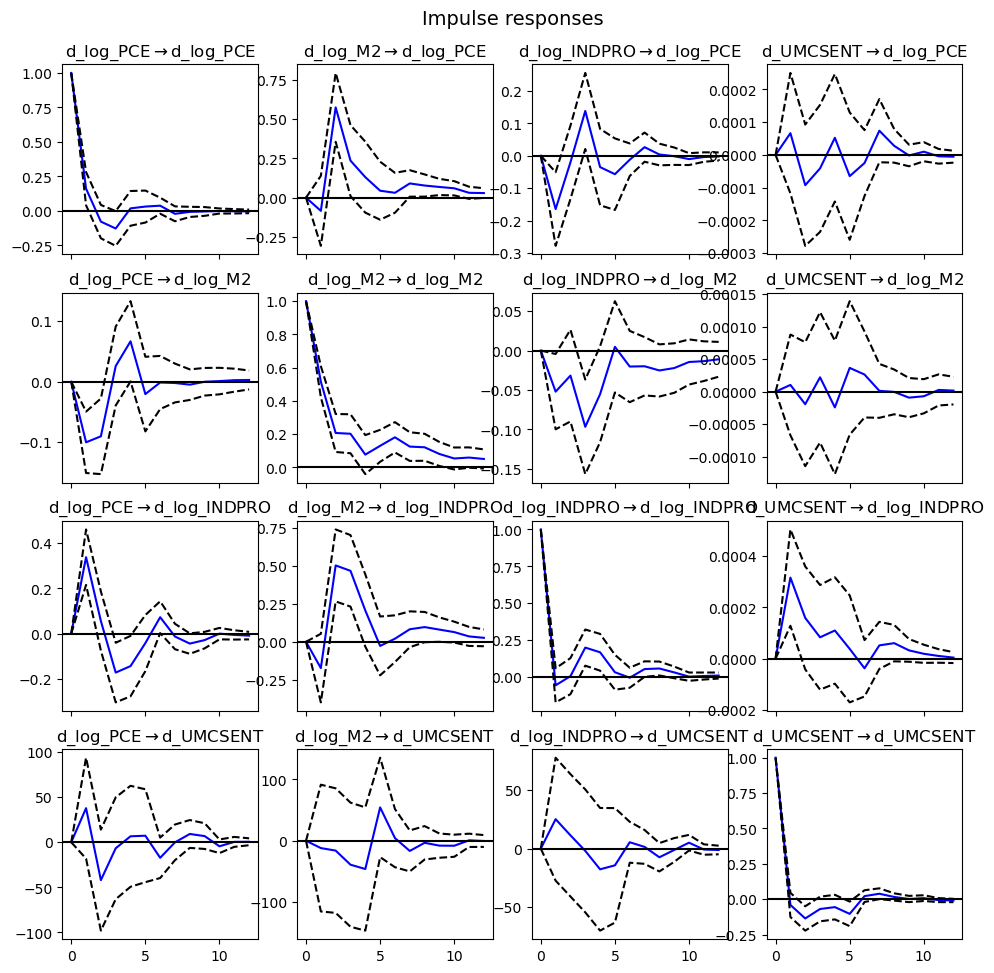

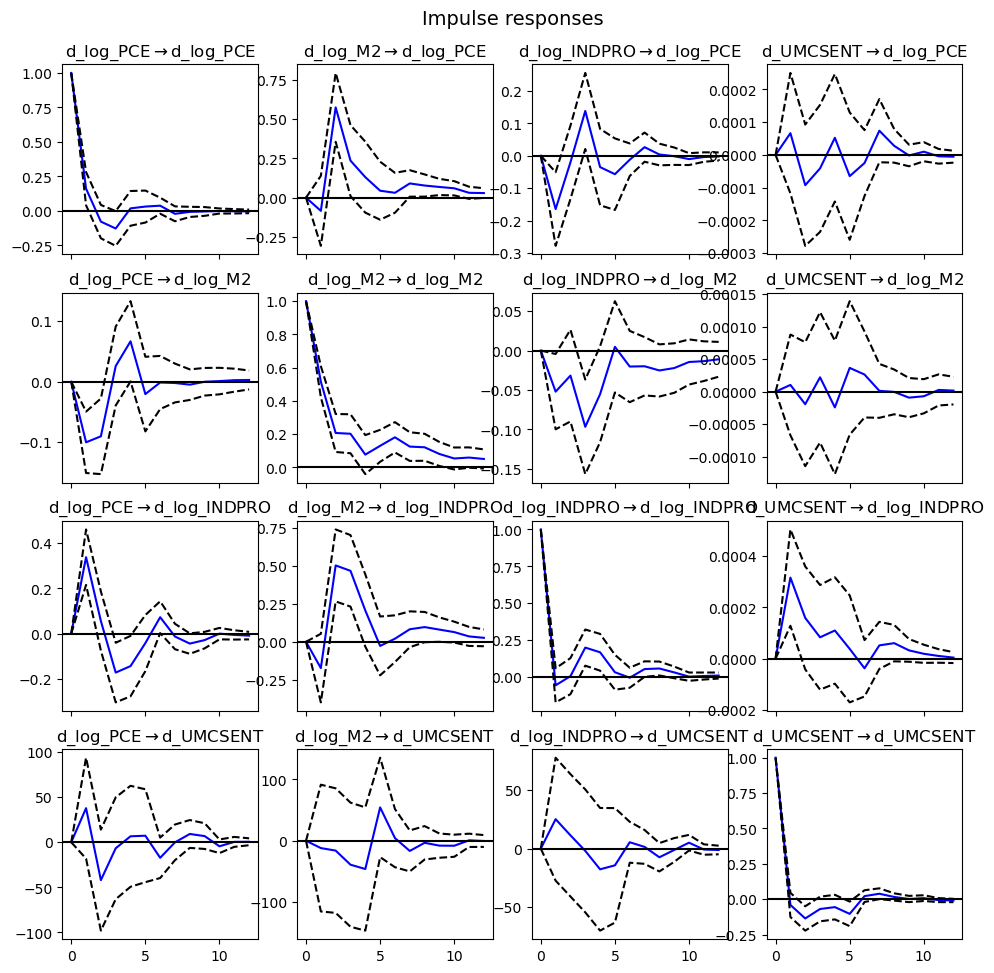

In [30]:
irf = var_result.irf(12)                
irf.plot()

Understanding the Axes of IRF Plots
-

Each Impulse Response Function (IRF) plot has two key axes:

- **X-axis: Duration (Time)**

- **Y-axis: Magnitude (Size of Response)**

Together, these axes allow us to evaluate the **direction**, **strength**, and **persistence** of the impact of shocks on economic variables.


Impulse Response Function (IRF) Summary
-
Consumption Growth: Rises briefly after own or M2 shocks; stable response to INDPRO; little effect from sentiment.

Money Supply Growth: Strong self-response; minor effects from PCE, INDPRO, and sentiment.

Industrial Production Growth: Increases after PCE and M2 shocks; persistent self-response; sentiment has little impact.

Consumer Sentiment Growth: Weak, short-lived effects from all shocks; strongest but brief response to own shock.

Step 14: Forecast Error Variance Decomposition (FEVD)
--
In this section:

We will compute and visualize the FEVD for all variables in the VAR system.

This analysis will show, for each time horizon, what fraction of the forecast error in variables like log(PCE), log(M2), log(INDPRO), or UMCSENT is attributable to shocks in every other variable.

By interpreting FEVD, we gain insight into the relative influence and dynamic importance of each macroeconomic factor in shaping the system’s evolution and forecast risk.


FEVD for d_log_PCE
      d_log_PCE  d_log_M2  d_log_INDPRO  d_UMCSENT
0      1.000000  0.000000      0.000000   0.000000
1      0.984082  0.000368      0.014665   0.000885
2      0.939010  0.045030      0.013579   0.002381
3      0.925404  0.049417      0.022541   0.002637
4      0.922401  0.051400      0.023081   0.003118
5      0.919892  0.051796      0.024454   0.003858
6      0.919605  0.051929      0.024500   0.003965
7      0.917837  0.052494      0.024737   0.004932
8      0.917131  0.053088      0.024717   0.005064
9      0.916621  0.053621      0.024697   0.005060
10     0.916161  0.054035      0.024730   0.005073
11     0.916043  0.054151      0.024731   0.005075

FEVD for d_log_M2
      d_log_PCE  d_log_M2  d_log_INDPRO  d_UMCSENT
0      0.196453  0.803547      0.000000   0.000000
1      0.325311  0.669114      0.005495   0.000081
2      0.369416  0.623557      0.006704   0.000324
3      0.366840  0.610168      0.022377   0.000616
4      0.363680  0.608149      0.027192   0.

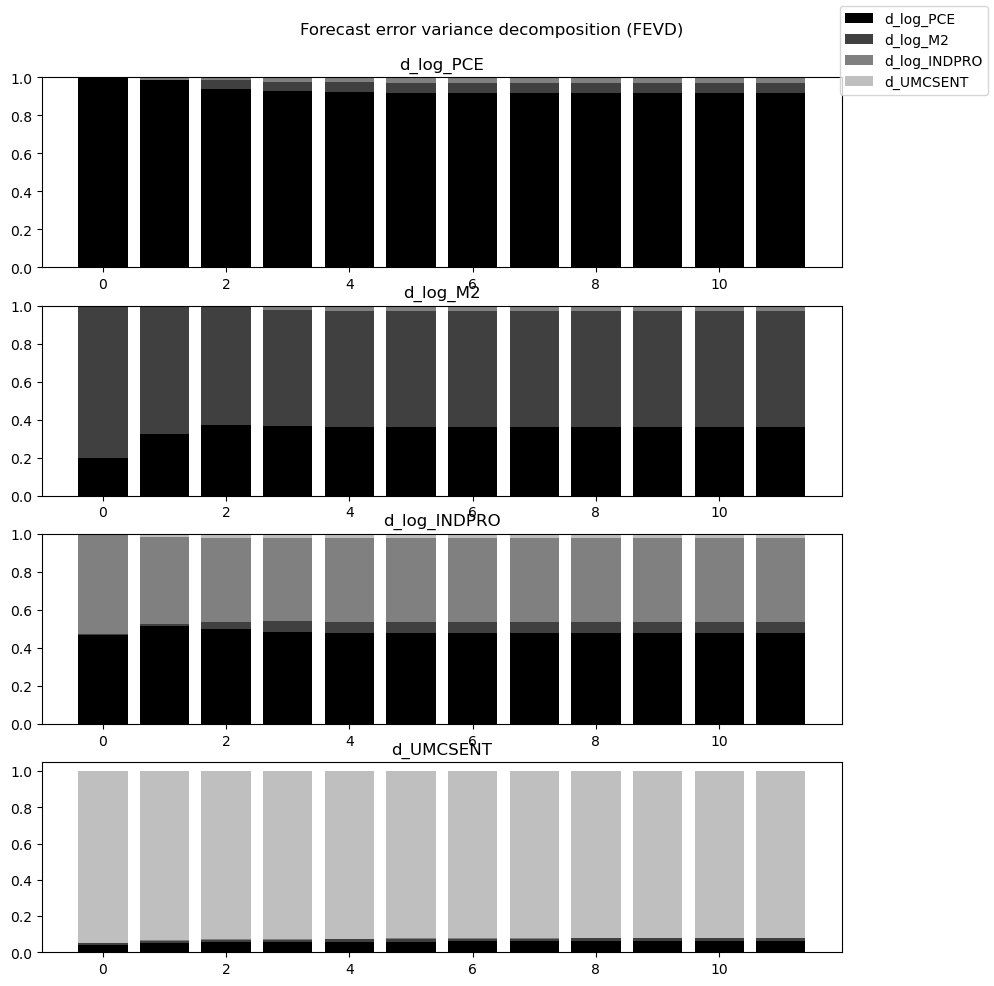

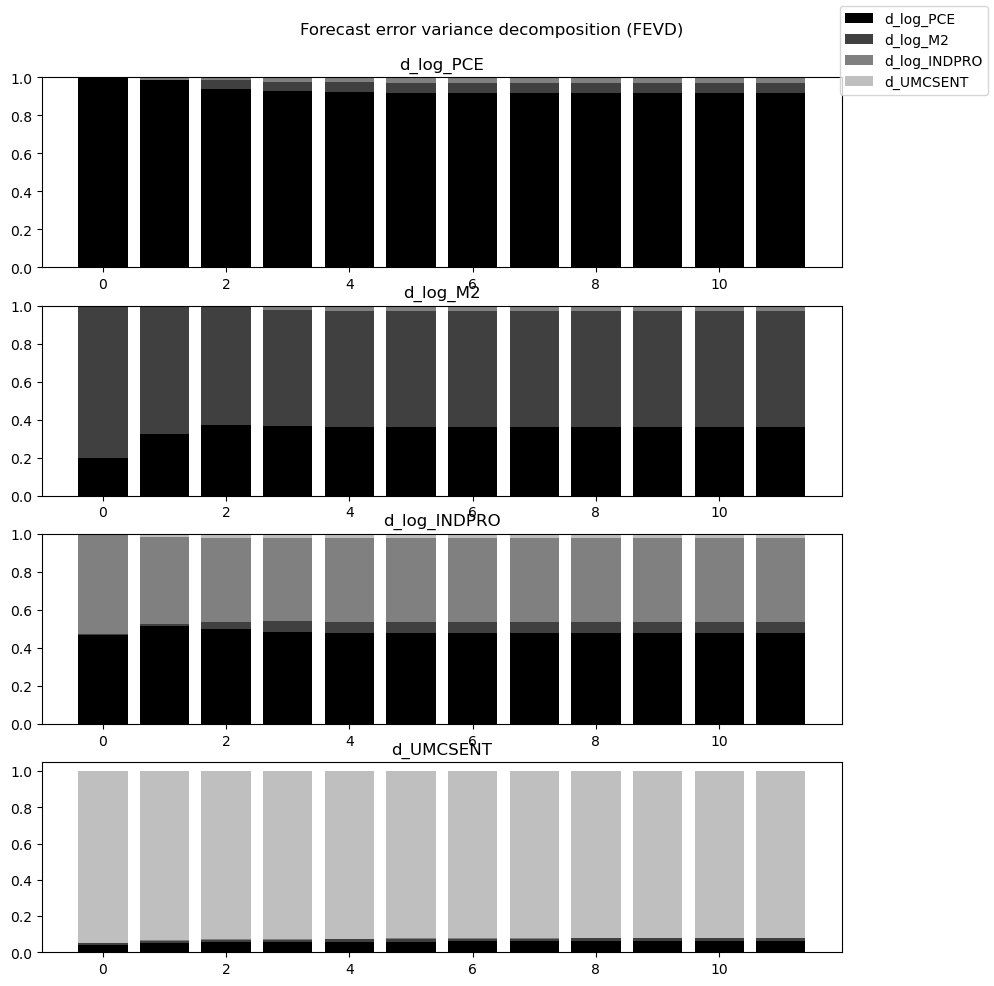

In [31]:
fevd = var_result.fevd(12)  
fevd.summary()
fevd.plot()


📊 Forecast Error Variance Decomposition (FEVD) – Interpretation
-
Consumption (d_log_PCE): ~90–95% driven by own shocks. Minor influence from M2, INDPRO; sentiment negligible.

→ Consumption is largely self-driven.

Money Supply (d_log_M2): ~60–65% own shocks, ~35–40% from PCE. INDPRO and sentiment have little impact.

→ Money supply reacts to consumption demand.

Industrial Production (d_log_INDPRO): ~50% own shocks, ~40–45% from PCE. M2 and sentiment contribute little.

→ Output driven by both internal momentum and consumer demand.

Consumer Sentiment (d_UMCSENT): ~90–95% from own shocks. Minimal effect from all other variables.

→ Sentiment is self-persistent and slow to react.

✅ Conclusion
--

This VAR-based macroeconomic analysis uncovers a strong, short-run interaction between real (PCE, INDPRO) and nominal (M2) variables in the U.S. economy. The results indicate a feedback-driven structure where:

Monetary aggregates (M2) are not purely exogenous, but respond to real-side dynamics, particularly consumption (PCE) and output (INDPRO).

Consumption (PCE) and industrial production (INDPRO) reinforce each other, validating a demand-pull mechanism.

Consumer sentiment (UMCSENT) behaves autonomously, largely uninfluenced by core macroeconomic variables, suggesting its evolution is driven by external psychological or geopolitical factors.

🧭 Policy Implications
-
Monetary Policy: Design policies that respond to real-time consumption, not just inflation/output gaps. M2’s sensitivity to PCE suggests a need for dynamic, responsive frameworks.

Industrial Output: Boost with combined fiscal (e.g., transfers, tax cuts) and monetary stimulus. Speed up supply-side adjustments to meet demand quickly.

Consumer Behavior: Focus on expectation management through clear, credible communication.Use behavioral tools (e.g., financial literacy, confidence campaigns) to influence sentiment.

Forecasting: Use consumption to improve output forecasts and vice versa.Treat sentiment as a potential early warning signal in uncertain times.
